 - hash name
 - get python types from function type
 - add a compile function that takes (name, input types, output types) and returns a callable

In [1]:
from pathlib import Path

from xdsl.builder import ImplicitBuilder
from xdsl.dialects import arith, func, memref, scf
from xdsl.dialects.builtin import FloatAttr, IndexType, IntegerAttr, ModuleOp, f64, i64
from xdsl.ir import Block, Region

index = IndexType()

def get_module(n: int) -> ModuleOp:
    memref_t = memref.MemRefType.from_element_type_and_shape(f64, [n])
    module = ModuleOp([])
    with ImplicitBuilder(module.body):
        f = func.FuncOp("hello", ((i64, i64), (i64,)))
        with ImplicitBuilder(f.body) as (lhs, rhs):
            res = arith.Addi(lhs, rhs).result
            func.Return(res)

        g = func.FuncOp("dist", ((memref_t, memref_t), (f64,)))
        with ImplicitBuilder(g.body) as (lhs, rhs):
            zero = arith.Constant(IntegerAttr( 0, index)).result
            one = arith.Constant(IntegerAttr( 1, index)).result
            hundo = arith.Constant(IntegerAttr( n, index)).result

            initial = arith.Constant(FloatAttr(0.0, f64)).result

            body = Region(Block(arg_types=(index, f64)))
            norm_squared = scf.For(zero, hundo, one, (initial,), body)
            with ImplicitBuilder(norm_squared.body) as (i, acc):
                lhs_el = memref.Load.get(lhs, (i,)).res
                rhs_el = memref.Load.get(rhs, (i,)).res
                sq = arith.Mulf(lhs_el, rhs_el).result
                new_acc = arith.Addf(acc, sq)
                scf.Yield(new_acc)

            func.Return(norm_squared)

    return module

m = get_module(100)
m_str = str(m)

with open(Path() / "input.mlir", 'w') as f:
    f.write(m_str)

/Users/sasha/Developer/xdslproject/xdsl/xdsl/utils/deprecation.py:18: UserWarning: Call to deprecated method MemRefType.from_element_type_and_shape: use the constructor (`ClassName(...)`) instead.
  warnings.warn(


In [2]:
import ctypes

from xdsl.jit import jit_module

dbl_ptr_type = ctypes.POINTER(ctypes.c_double)

hey = jit_module(m, "hello", types=((int, int), int))
dist_mlir = jit_module(m, "dist", types=((dbl_ptr_type, dbl_ptr_type), float))
hey(5,6)

11

In [3]:
import numpy as np

In [4]:
n = 10000
a = np.random.random(n)
b = np.random.random(n)

In [5]:
a_data_ptr = a.ctypes.data_as(dbl_ptr_type)
b_data_ptr = b.ctypes.data_as(dbl_ptr_type)
%time dist_mlir(a_data_ptr, b_data_ptr)

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 8.34 µs


27.688617729996096

In [6]:
%time hey(5, 6)

CPU times: user 7 µs, sys: 3 µs, total: 10 µs
Wall time: 10.7 µs


11

In [7]:
%time 1 + 2

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.15 µs


3

In [8]:
from typing import Any


def dist_np(lhs: np.ndarray[Any, np.dtype[np.float64]], rhs: np.ndarray[Any, np.dtype[np.float64]]) -> np.float64:
    return lhs.dot(rhs)

%time dist_np(a, b)

CPU times: user 18 µs, sys: 6 µs, total: 24 µs
Wall time: 22.9 µs


2501.373855475613

In [9]:
def dist_python(lhs: np.ndarray[Any, np.dtype[np.float64]], rhs: np.ndarray[Any, np.dtype[np.float64]]) -> np.float64:
    res = np.float64(0.0)
    for l, r in zip(lhs, rhs):
        res += l * r
    return res

%time dist_python(a, b)

CPU times: user 3.08 ms, sys: 7 µs, total: 3.08 ms
Wall time: 917 µs


2501.3738554756155

In [10]:
import timeit

timeit.timeit(lambda: dist_python(a, b), number=100)

0.10218562511727214

In [11]:
import pandas as pd

In [12]:
from collections import defaultdict

In [13]:
res = defaultdict[str, list[float]](list)

powers = [int(10 ** i) for i in range(1, 6)]

for n in powers:
    a = np.random.random(n)
    b = np.random.random(n)
    dist_mlir_i = jit_module(get_module(n), "dist", types=((dbl_ptr_type, dbl_ptr_type), float))
    a_data_ptr = a.ctypes.data_as(dbl_ptr_type)
    b_data_ptr = b.ctypes.data_as(dbl_ptr_type)
    res["mlir"].append(timeit.timeit(lambda: dist_mlir_i(a_data_ptr, b_data_ptr), number=100))
    res["numpy"].append(timeit.timeit(lambda: dist_np(a, b), number=100))
    res["python"].append(timeit.timeit(lambda: dist_python(a, b), number=100))

res

/Users/sasha/Developer/xdslproject/xdsl/xdsl/utils/deprecation.py:18: UserWarning: Call to deprecated method MemRefType.from_element_type_and_shape: use the constructor (`ClassName(...)`) instead.
  warnings.warn(
/Users/sasha/Developer/xdslproject/xdsl/xdsl/utils/deprecation.py:18: UserWarning: Call to deprecated method MemRefType.from_element_type_and_shape: use the constructor (`ClassName(...)`) instead.
  warnings.warn(
/Users/sasha/Developer/xdslproject/xdsl/xdsl/utils/deprecation.py:18: UserWarning: Call to deprecated method MemRefType.from_element_type_and_shape: use the constructor (`ClassName(...)`) instead.
  warnings.warn(
/Users/sasha/Developer/xdslproject/xdsl/xdsl/utils/deprecation.py:18: UserWarning: Call to deprecated method MemRefType.from_element_type_and_shape: use the constructor (`ClassName(...)`) instead.
  warnings.warn(


defaultdict(list,
            {'mlir': [0.0018562921322882175,
              0.0005725000519305468,
              0.001130291959270835,
              0.006798125104978681,
              0.061717333970591426],
             'numpy': [5.641602911055088e-05,
              3.9125094190239906e-05,
              0.00011925003491342068,
              0.0005673330742865801,
              0.00467541697435081],
             'python': [0.00014399993233382702,
              0.0009146658703684807,
              0.01179254218004644,
              0.08755708299577236,
              0.922177542001009]})

In [14]:
df = pd.DataFrame(res, index=powers)
df

,mlir,numpy,python
10,0.001856,0.000056,0.000144
100,0.000573,0.000039,0.000915
1000,0.001130,0.000119,0.011793
10000,0.006798,0.000567,0.087557
100000,0.061717,0.004675,0.922178


In [15]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


<Axes: ylabel='seconds'>

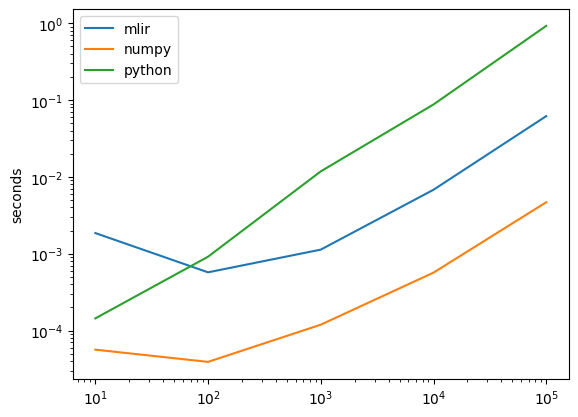

In [16]:
df.plot(logy=True, logx=True, ylabel="seconds")